In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression

from helper_functions import *

import warnings
warnings.filterwarnings('ignore')

In [4]:
# Read csv files
train_df = pd.read_csv("DailyDelhiClimateTrain.csv", parse_dates=True,index_col='date')
test_df = pd.read_csv("DailyDelhiClimateTest.csv", parse_dates=True,index_col='date')

## EDA (Exploratory Data Analysis)

In [5]:
train_df.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [6]:
train_df.tail()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2016-12-28,17.217391,68.043478,3.547826,1015.565217
2016-12-29,15.238095,87.857143,6.000000,1016.904762
2016-12-30,14.095238,89.666667,6.266667,1017.904762
2016-12-31,15.052632,87.000000,7.325000,1016.100000
2017-01-01,10.000000,100.000000,0.000000,1016.000000


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1462 entries, 2013-01-01 to 2017-01-01
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   meantemp      1462 non-null   float64
 1   humidity      1462 non-null   float64
 2   wind_speed    1462 non-null   float64
 3   meanpressure  1462 non-null   float64
dtypes: float64(4)
memory usage: 57.1 KB


In [8]:
train_df.describe()

,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


In [9]:
train_df.columns

Index(['meantemp', 'humidity', 'wind_speed', 'meanpressure'], dtype='object')

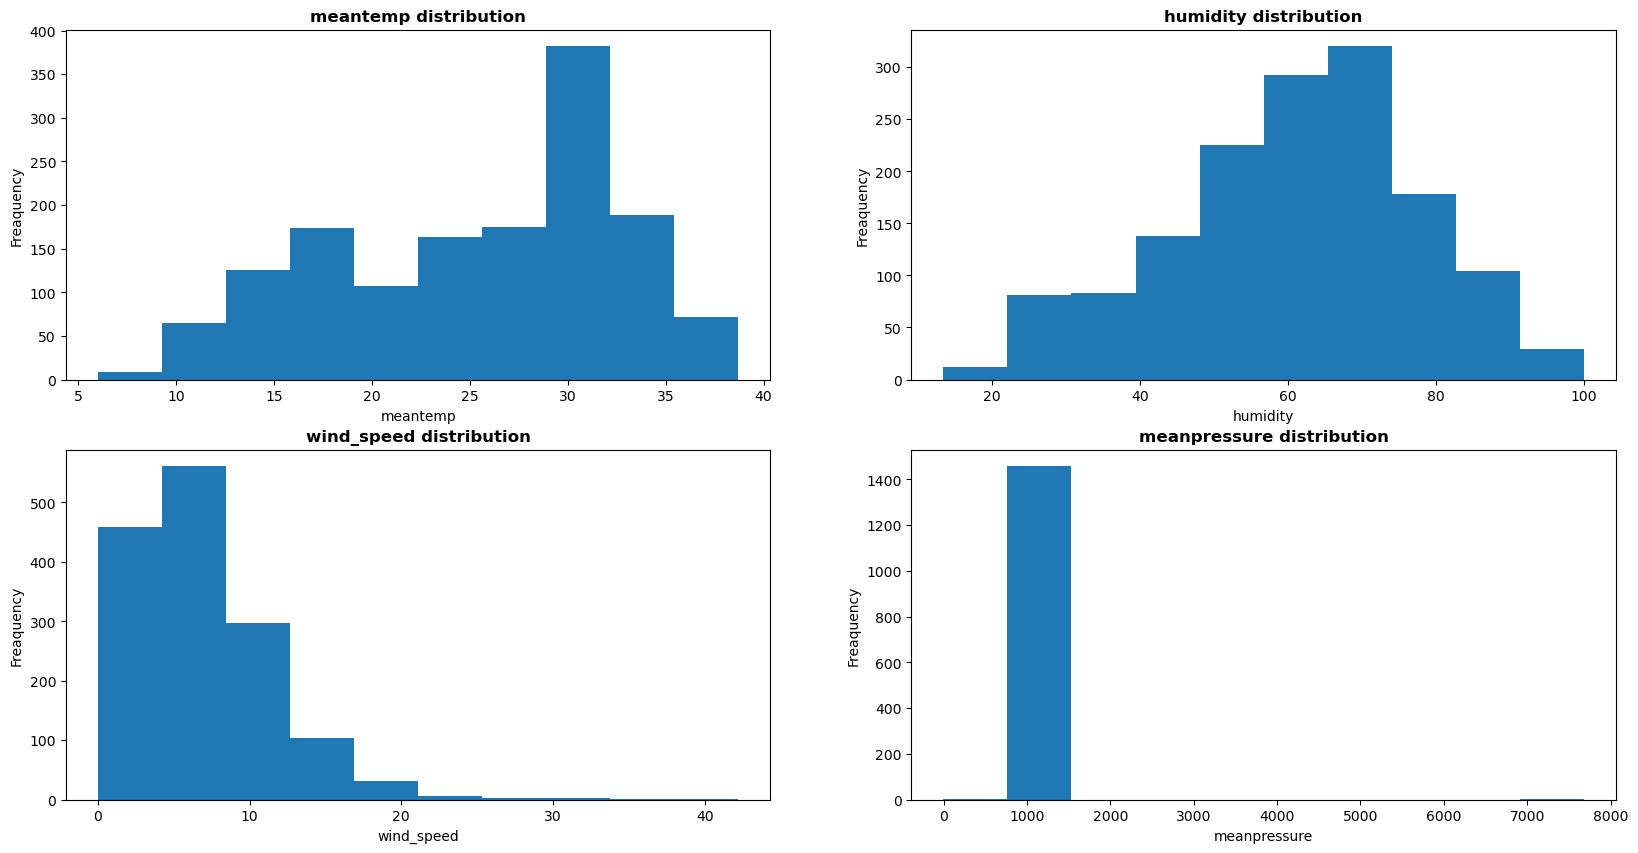

In [10]:
# Let's see the data disribution
plt.figure(figsize=(20, 10))

subplot_index = 1 # Initailize counter for subplot index

for col in train_df.columns:
    plt.subplot(2, 2, subplot_index)
    plt.hist(train_df[col])
    plt.xlabel(col)
    plt.ylabel('Freaquency')
    plt.title(f'{col} distribution', weight='bold')

    subplot_index += 1 # Increment the subplot index



#### meanpressure distribution is the has the the most skewed distribution  followed by wind speed

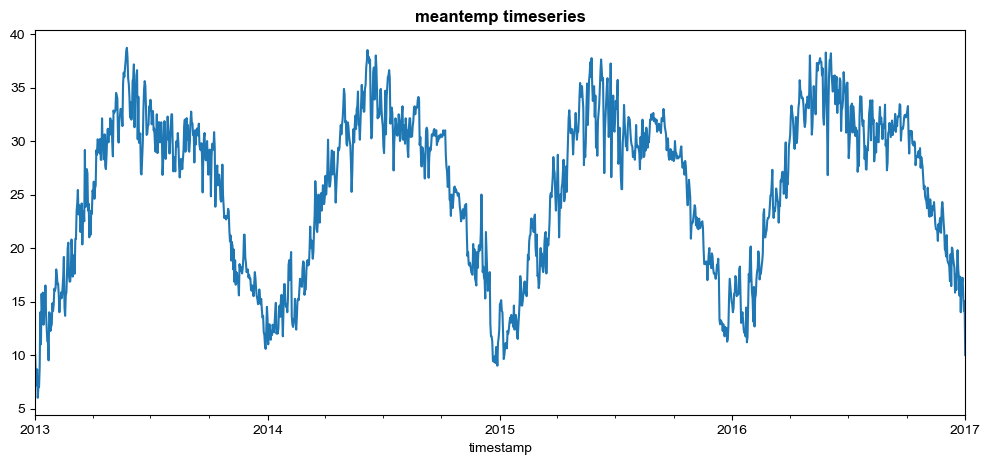

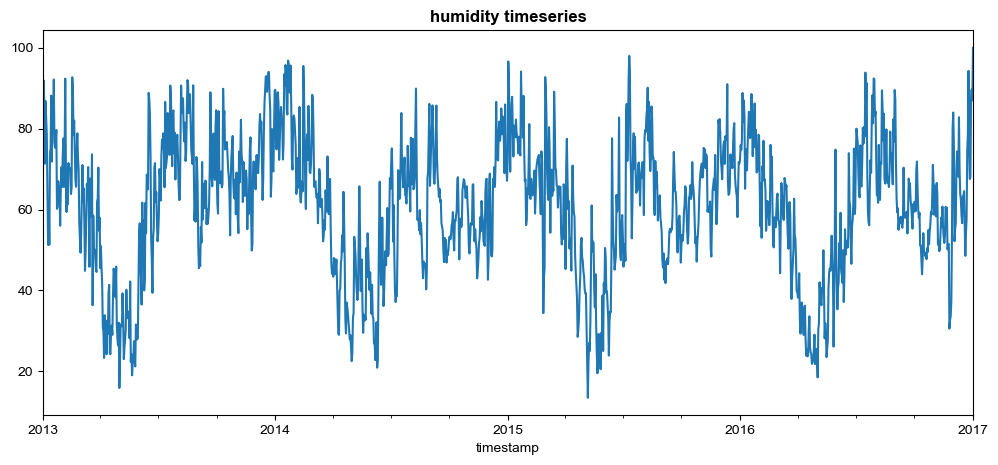

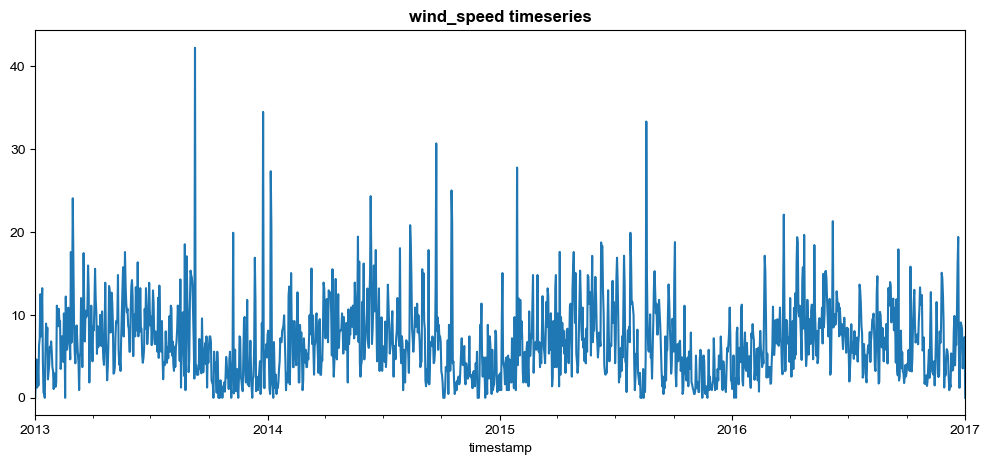

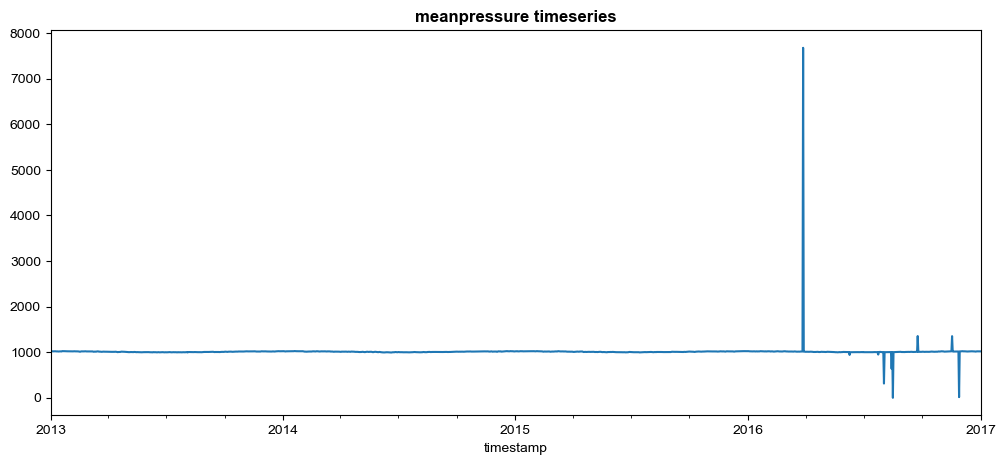

In [11]:
for col in train_df.columns:
    fig = plt.figure(figsize=(12, 5))
    train_df[col].plot()
    plt.xlabel('timestamp')
    plt.title(f'{col} timeseries', weight='bold');


sns.set()

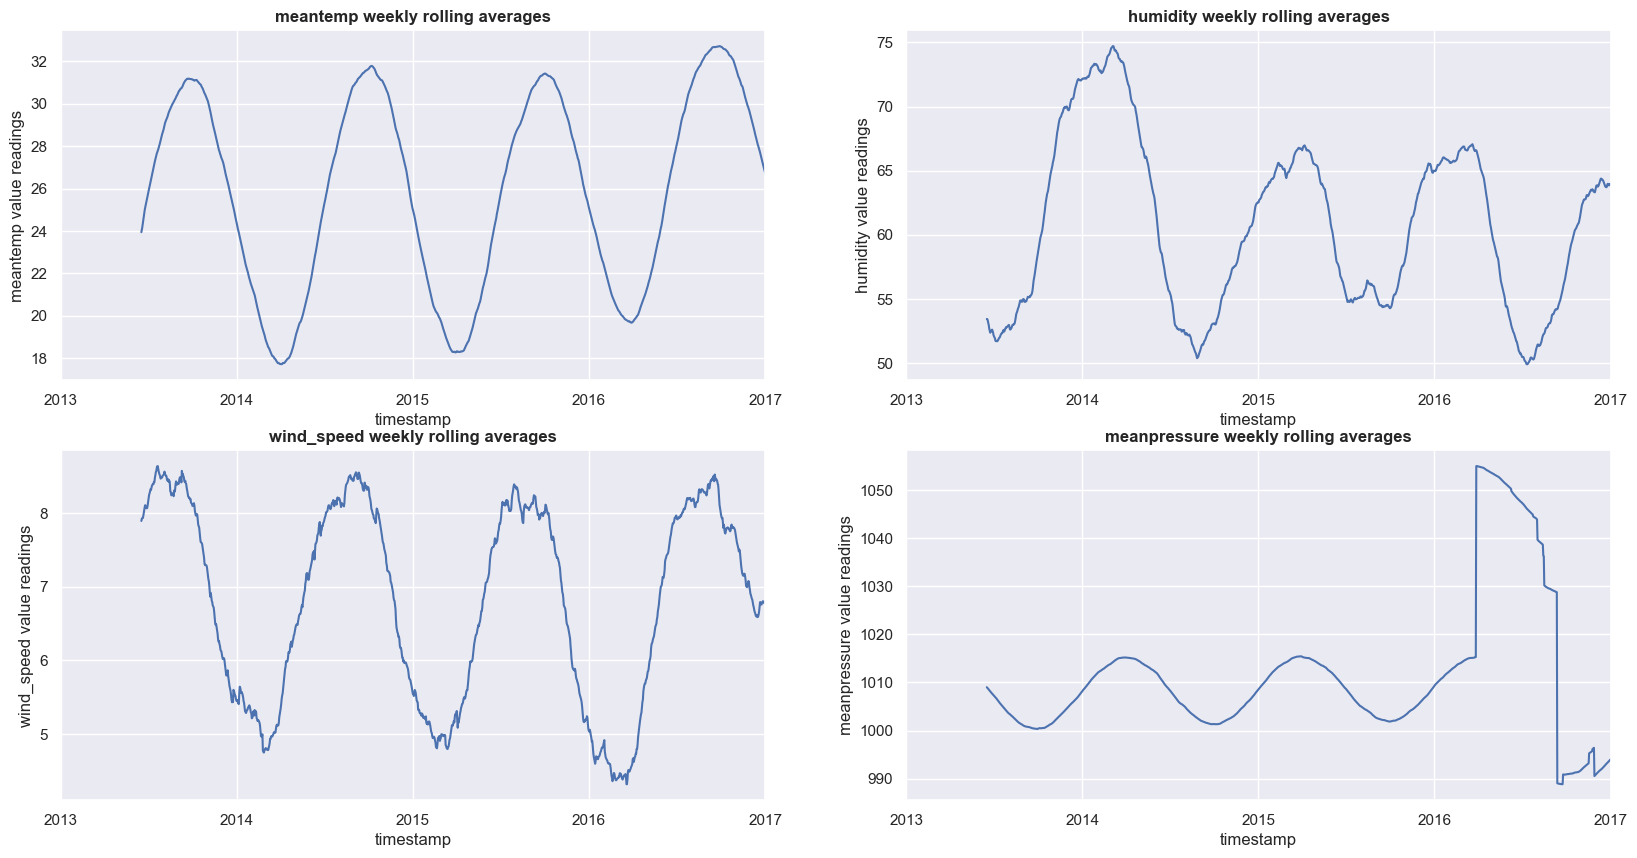

In [12]:
# Let's see the data disribution
plt.figure(figsize=(20, 10))

subplot_index = 1 # Initailize counter for subplot index

for col in train_df.columns:
    plt.subplot(2, 2, subplot_index)
    train_df[col].rolling(168).mean().plot()
    plt.xlabel('timestamp')
    plt.ylabel(f'{col} value readings' )
    plt.title(f'{col} weekly rolling averages', weight='bold');

    subplot_index += 1 # Increment the subplot index

sns.set()

## Building a Time Series Model

In [13]:
y_train, X_train = get_feature_and_target(train_df, 'meantemp')

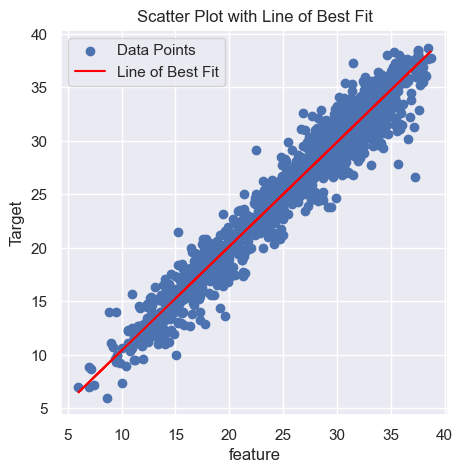

In [14]:
### Plot a line of best fit
x = X_train.squeeze()  #feature
y = y_train.squeeze()  #target

fig, ax = plt.subplots(figsize=(5, 5))
ax.scatter(x, y, label='Data Points')
slope, intercept = np.polyfit(x, y, 1)

# get the line of best fit equation (y = mx + c)
line_of_best_fit = slope * x + intercept

ax.plot(x, line_of_best_fit, color='red', label='Line of Best Fit')

ax.legend()
ax.set_xlabel('feature')
ax.set_ylabel('Target')
ax.set_title('Scatter Plot with Line of Best Fit');


### Build Baseline Model

In [15]:
# Assumption if our moddel is predicting the mean of the training target variable
y_train_mean = y_train.mean()
y_pred_baseline = [y_train_mean] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)
print(round(mae_baseline, 4))

6.355


### Iterate

In [16]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

### Evaluate model performance

In [17]:
y_test, X_test = get_feature_and_target(test_df, 'meantemp')


training_mae = mean_absolute_error(y_train, model.predict(X_train))
test_mae = mean_absolute_error(y_test, model.predict(X_test))
print('Training MAE:', training_mae)
print('Test MAE:', test_mae)

if training_mae < mae_baseline:
    print('\n'"Hurray!!! training Mean absolute error beat the baseline.")
if test_mae < mae_baseline:
    print("Hurray!!! test Mean absolute error beat the baseline.")


Training MAE: 1.2438951205723838
Test MAE: 1.3038764919008448

Hurray!!! training Mean absolute error beat the baseline.
Hurray!!! test Mean absolute error beat the baseline.


### Communicate Results

In [18]:
intercept = model.intercept_.round(2)
coefficient = model.coef_.round(2)[0]

print(f"meantemp = {intercept} + ({coefficient} * meantemp_L1)") # line of best fit equation y=mx+c

meantemp = 0.66 + (0.97 * meantemp_L1)


In [19]:
df_pred_test = pd.DataFrame(
    {'y_test' : y_test,
     'y_pred' : model.predict(X_test)
    })

fig = px.line(df_pred_test, labels = ('Value: meantemp'))
fig.show();

### Model is doing a good job in predicting the future values